In [1]:
import numpy as np
import sys
sys.path.append('./../gp_sinkhorn/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
import matplotlib.pyplot as plt
from MLE_drift import *
import torch

from celluloid import Camera
from IPython.display import HTML
import math

from functools import partial
import pyro
from pyro.contrib.gp.kernels import Exponential, Matern32, RBF, Brownian, Combination, Product, Sum

In [2]:
import torch
from torch.distributions import constraints

from pyro.contrib.gp.kernels.kernel import Kernel
from pyro.nn.module import PyroParam


def _torch_sqrt(x, eps=1e-12):
    """
    A convenient function to avoid the NaN gradient issue of :func:`torch.sqrt`
    at 0.
    """
    # Ref: https://github.com/pytorch/pytorch/issues/2421
    return (x + eps).sqrt()


class IntegratedBrownian(Kernel):
    r"""
    This kernel correponds to a two-sided Brownion motion (Wiener process):
        :math:`k(x,z)=\begin{cases}\sigma^2\min(|x|,|z|),& \text{if } x\cdot z\ge 0\\
        0, & \text{otherwise}. \end{cases}`
    Note that the input dimension of this kernel must be 1.
    Reference:
    [1] `Theory and Statistical Applications of Stochastic Processes`,
    Yuliya Mishura, Georgiy Shevchenko
    """

    def __init__(self, input_dim, variance=None, active_dims=None):
        if input_dim != 1:
            raise ValueError("Input dimensional for Brownian kernel must be 1.")
        super().__init__(input_dim, active_dims)

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)
    
    def _dist(self, X, Z=None):
        r"""
        Returns :math:`\|\frac{X-Z}{l}\|^2`.
        """
        if Z is None:
            Z = X
#         X = self._slice_input(X)
#         Z = self._slice_input(Z)
        if X.size(1) != Z.size(1):
            raise ValueError("Inputs must have the same number of features.")

        scaled_X = X 
        scaled_Z = Z 
        X2 = (scaled_X ** 2).sum(1, keepdim=True)
        Z2 = (scaled_Z ** 2).sum(1, keepdim=True)
        XZ = scaled_X.matmul(scaled_Z.t())
        r2 = X2 - 2 * XZ + Z2.t()
        return _torch_sqrt(r2.clamp(min=0))
    
    def forward(self, X, Z=None, diag=False):
        if Z is None:
            Z = X
            
        X = self._slice_input(X)
        if diag:
            return self.variance * X.abs().squeeze(1)

        Z = self._slice_input(Z)

        if X.size(1) != Z.size(1):
            raise ValueError("Inputs must have the same number of features.")

        Zt = Z.t()
        
        min_ = torch.min(X.abs(), Zt.abs())
        min_sq = 0.5 * self._dist(X,Z) *  min_**2
        min_cb = min_**3 /  3.0
        
        
        return torch.where(X.sign() == Zt.sign(),
                           self.variance * (min_sq + min_cb),
                           X.data.new_zeros(X.size(0), Z.size(0)))

# Double well

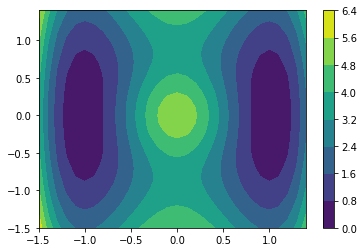

In [3]:
feature_x = np.arange(-1.5, 1.5, 0.1)
feature_y = np.arange(-1.5, 1.5, 0.1)
x, y = np.meshgrid(feature_x, feature_y)

delta = 0.35
fac = 1
fac_ = 1
z = (fac_*5/2.0)*(x**2-1)**2+y**2 +  fac*np.exp(-(  x**2 +y**2)/delta)/delta
 

#  -2 *x/delta*np.exp(-(  x**2 +y**2)/delta)/delta
#  (-( 2*y)/delta )*np.exp(-(  x**2 +y**2)/delta)/delta

h = plt.contourf(feature_x,feature_y,z)
plt.colorbar()
plt.show()



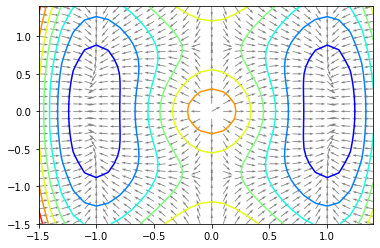

In [4]:
u = -(fac_*10*x*(x**2-1)) + fac* 2 * x * np.exp(-(  x**2 +y**2)/delta)/delta**2
v = -(2*y)  + fac * 2* y * np.exp(-(  x**2 +y**2)/delta)/delta**2

norm = np.linalg.norm(np.array((u, v)), axis=0)
u = (u / norm)*0.1
v = (v / norm)*0.1

fig, ax = plt.subplots(1, 1)

ax.quiver(x, y, u, v, units='xy', scale=1, color='gray')
ax.contour(x, y, z, 7, cmap='jet')


In [5]:
delta_tn = torch.tensor(delta)

deriv_x = lambda x,y: -(fac_ * 10*x*(x**2-1)) +  2 * x * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
deriv_y = lambda x,y: -(2*y) +2* y * torch.exp(-(  x**2 +y**2)/delta_tn)/delta_tn**2
# deriv_y = deriv_x
# prior_drift = lambda X: torch.tensor([[deriv_x(i[0]),deriv_y(i[1])] for i in X])

prior_drift = lambda X: torch.tensor([[deriv_x(i[0],i[1]),deriv_y(i[0],i[1])] for i in X])

In [6]:
num_samples=100
sigma = 0.5
dt = 0.02
N = int(math.ceil(1.0/dt))
mu_0 = torch.tensor([1.0,0.0])

eye_ = torch.diag(torch.tensor([0.25,3]))
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_0, eye_*0.05).sample((num_samples,1)).reshape((-1,2)).double()
mu_1 = torch.tensor([-1.0,0.0])
X_1 = torch.distributions.multivariate_normal.MultivariateNormal(mu_1,eye_ * 0.05).sample((num_samples,1)).reshape((-1,2)).double()

mu_2 = torch.tensor([0.0,0.0])
X_2 = torch.distributions.multivariate_normal.MultivariateNormal(mu_2,torch.eye(2)*0.5).sample((250,1)).reshape((-1,2))

prior_X_0 = X_2.double()
t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=prior_X_0, dt=dt, N=N)
#plot_trajectories_2(Xts, t, remove_time=True)

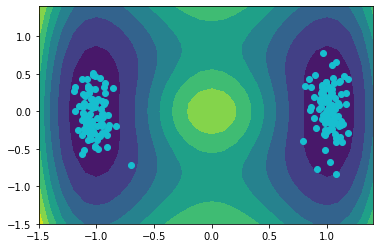

In [7]:

t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=torch.cat((X_1, X_0)), dt=dt, N=N)
fig = plt.figure()
camera = Camera(fig)
for i in range(N):    
    plt.contourf(feature_x,feature_y,z)
    plt.scatter(Xts[:,i,0].detach(),Xts[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')



In [12]:
N

50

In [ ]:
# torch.cat((X_0,X_1))
# torch.cat((prior_X_0,X_0,X_1))
# partial(Exponential, lengthscale=torch.tensor(0.5)
def kern_mix_1(input_dim):
    return pyro.contrib.gp.kernels.Product(
        pyro.contrib.gp.kernels.Exponential(
            input_dim=3,
            lengthscale=torch.tensor(0.5),
            active_dims=[0,1,2]
        ), 
        Brownian(input_dim=1, active_dims=[1], variance=torch.tensor(math.sqrt(1.5))) #pyro.contrib.gp.kernels.Brownian(input_dim=1, active_dims=[1])
    )


def kern_mix_2(input_dim):
    return pyro.contrib.gp.kernels.Product(
        pyro.contrib.gp.kernels.RBF(
            input_dim=2,
            lengthscale=torch.tensor(0.5),
            active_dims=[0,1]
        ), 
        Brownian(input_dim=1, active_dims=[2], variance=torch.tensor(math.sqrt(1))) #pyro.contrib.gp.kernels.Brownian(input_dim=1, active_dims=[1])
    )

def kern_mix_3(input_dim):
    return pyro.contrib.gp.kernels.Product(
        pyro.contrib.gp.kernels.Exponential(
            input_dim=2,
            lengthscale=torch.tensor(0.5),
            active_dims=[0,1]
        ), 
        IntegratedBrownian(input_dim=1, active_dims=[2], variance=torch.tensor(math.sqrt(1))) #pyro.contrib.gp.kernels.Brownian(input_dim=1, active_dims=[1])
    )

def kern_mix_4(input_dim):
    return pyro.contrib.gp.kernels.Exponential(
            input_dim=3,
            lengthscale=torch.tensor(0.5),
            active_dims=[0,1,2]
        )

result = MLE_IPFP(
    X_0,X_1,N=N,sigma=0.3,
    prior_drift=prior_drift, sparse=False, 
    prior_X_0=prior_X_0, iteration=10, refinement_iterations=0,
    decay_sigma=1, gp_mean_prior_flag=False, kernel=kern_mix_1
)

In [ ]:
fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')

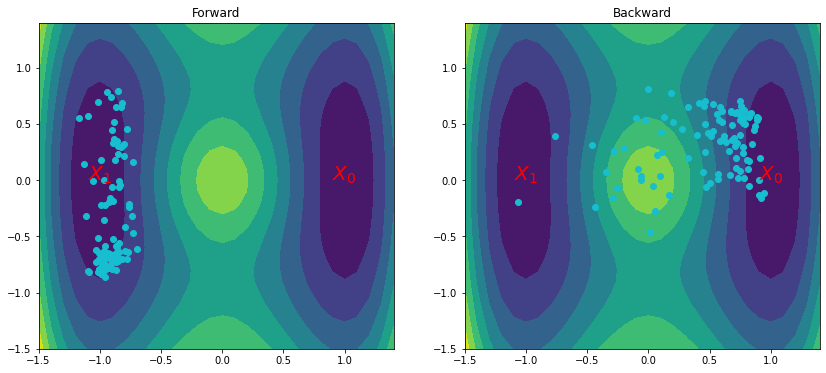

In [39]:


fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[2][1]
M2 = result[2][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')

Text(-1.1, 0, '$X_1$')

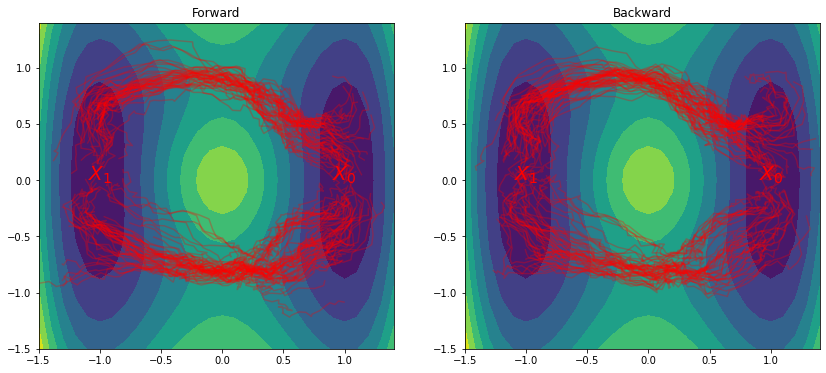

In [27]:
fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))

M = result[-1][1]
M2 = result[-1][3]
for i in range(len(M)): 
   
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)

    μ10 = M[i,:,0].detach()#.mean(axis=0)
    μ11 = M[i,:,1].detach()#.mean(axis=0)
#     σ10 = M[i,:,0].detach().std(axis=0)
#     σ11 = M[i,:,1].detach().std(axis=0)

    μ20 = M2[i,:,0].detach()#.mean(axis=0)
    μ21 = M2[i,:,1].detach()#.mean(axis=0)
#     σ20 = M2[i,:,0].detach().std(axis=0)
#     σ21 = M2[i,:,1].detach().std(axis=0)

    ax1.plot(μ10, μ11, alpha=.3, color="red")
    ax2.plot(μ20, μ21, alpha=.3, color="red")

# ax1.plot(μ10, μ11 + 2*σ11)

# ax1.fill_between( μ11-2*σ11, μ11+2*σ11, alpha=.5)

# ax2.fill_between(μ20-2*σ20, μ21+2*σ21, alpha=.5)



ax1.set_title("Forward")
ax2.set_title("Backward")

ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')


In [28]:
import pandas as pd

pd.to_pickle(result, "nice_well_trajectory_10_iters_both_prior_bug_fix_exponential_0.5_best_split_brownian_exp_bsigma_0.8_perfection_besterino_2.pkl")

In [28]:
result_=pd.read_pickle("nice_well_trajectory_10_iters_both_prior_bug_fix_exponential_0.5_best_split_brownian_exp_bsigma_0.8_perfection.pkl")